# Exploratory Data Analysis (EDA)
Goals:
* Giving an overview of the data 
    * mutation counts (boxplot)
* Identifying knock-outs (KO) resulting in a distinctive mutational profile
    * Upregulation in Mutation count
    * Cluster in PCA (or UMAP)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.patches import Patch
import matplotlib.image as mpimg
from matplotlib import rcParams

import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import sigProfilerPlotting as sigPlt
import umap.umap_ as umap

%matplotlib inline

## Zou, 2021
Data exploration of [Zou (2021)](https://europepmc.org/article/pmc/pmc7611045)
 "A systematic CRISPR screen defines mutational mechanisms underpinning signatures caused by replication errors and endogenous DNA damage"  
 Available Data: [Mutation Data](https://data.mendeley.com/datasets/ymn3ykkmyx/2)
 * Single base substitutions (SBS)
 * Double base substitutions (DBS)
 * indels 
 * Rearrangements (rgs)
 
**CRISPR-Cas9 KO of 43 genes in human iPCS**
total 173 samples


### Parse Raw data

In [18]:
# pip install lckr-jupyterlab-variableinspector

^C
Note: you may need to restart the kernel to use updated packages.


In [2]:
def load_zou():
    '''
    Generate dataframe:
    173 samples 
    96 SBSs ; gene_KO ; Count ; Protein_KO ; Subpathway_KO
    '''
    xls = pd.ExcelFile('data/zou2021/Supplementary_tables.xlsx')
    # S3 = Mutational profiles per Sample  (96 x 173)
    profiles = pd.read_excel(xls, 'TableS3', index_col= 0,header= 0)
    # S1 = Gene - Pathway mapping   (43 KOs
    KO_pathway = pd.read_excel(xls, 'TableS1', index_col= 0, header= 0)
    # zou2021.rename(columns = {"Unnamed: 0":"Sample"}, inplace=True)

    # To look-up tables Gene <-> Pathway
    pathways = {}
    genes = {}
    for index, row in KO_pathway.iterrows():
        p = row['Subpathway_KO'].split('/')
        for i in p:
            if i in pathways:
                pathways[i].append(index)
            else:
                pathways[i] = [index]
            if index in genes:
                genes[index].append(i)
            else:
                genes[index] = [i]

    features = list(profiles.index)

    profiles = profiles.drop(columns=['Mutation'])
    samples = list(profiles.columns)
    count = profiles.sum(axis=0)
    profiles = profiles.loc[:,:].div(profiles.sum(axis=0), axis=1)
    profiles = profiles.transpose()
    gene_KO = []
    for s in samples:
        gene_KO.append(s.split('_')[0])
    profiles['Gene_KO'] = gene_KO
    profiles['Count'] = count
    joined = pd.merge(left=profiles, right=KO_pathway, how= 'left', left_on='Gene_KO', right_index = True)

    x = profiles.loc[:,features].values  # Separating out the target
    y = profiles.loc[:, 'Gene_KO'].values  # Standardizing the features

    return joined

zou = load_zou()
zou

,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,A[C>G]A,A[C>G]C,A[C>G]G,A[C>G]T,A[C>T]A,A[C>T]C,...,T[T>C]G,T[T>C]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T,Gene_KO,Count,Protein_KO,Subpathway_KO
ATM_148_s1,0.054152,0.003610,0.003610,0.014440,0.007220,0.000000,0.000000,0.003610,0.018051,0.007220,...,0.003610,0.007220,0.000000,0.000000,0.003610,0.003610,ATM,277,ATM serine/threonine kinase,Checkpoint/DSB repair/DSB repair pathway choice
ATM_148_s2,0.054902,0.000000,0.007843,0.039216,0.003922,0.000000,0.000000,0.000000,0.031373,0.003922,...,0.003922,0.015686,0.003922,0.000000,0.003922,0.007843,ATM,255,ATM serine/threonine kinase,Checkpoint/DSB repair/DSB repair pathway choice
ATM_16_s1,0.100000,0.002778,0.005556,0.027778,0.002778,0.000000,0.000000,0.008333,0.016667,0.000000,...,0.002778,0.008333,0.000000,0.000000,0.000000,0.002778,ATM,360,ATM serine/threonine kinase,Checkpoint/DSB repair/DSB repair pathway choice
ATM_16_s2,0.062731,0.007380,0.000000,0.029520,0.007380,0.000000,0.003690,0.003690,0.014760,0.011070,...,0.003690,0.014760,0.000000,0.003690,0.000000,0.007380,ATM,271,ATM serine/threonine kinase,Checkpoint/DSB repair/DSB repair pathway choice
ATP2B4_2_s3,0.069620,0.012658,0.000000,0.006329,0.000000,0.006329,0.000000,0.000000,0.037975,0.012658,...,0.006329,0.006329,0.000000,0.000000,0.000000,0.000000,ATP2B4,158,Plasma membrane calcium-transporting ATPase 4,Control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WRN_56_s4,0.046392,0.005155,0.015464,0.015464,0.010309,0.005155,0.000000,0.000000,0.020619,0.005155,...,0.000000,0.010309,0.000000,0.005155,0.000000,0.000000,WRN,194,Werner syndrome ATP-dependent helicase,Helicases/HR and HR regulation
XRCC4_77_s1,0.037815,0.000000,0.004202,0.012605,0.012605,0.000000,0.004202,0.000000,0.033613,0.016807,...,0.000000,0.008403,0.000000,0.000000,0.004202,0.008403,XRCC4,238,X-ray repair cross-complementing protein 4,NHEJ and MMEJ
XRCC4_77_s2,0.092166,0.004608,0.000000,0.018433,0.000000,0.004608,0.000000,0.004608,0.023041,0.004608,...,0.004608,0.009217,0.000000,0.000000,0.004608,0.000000,XRCC4,217,X-ray repair cross-complementing protein 4,NHEJ and MMEJ
XRCC4_78_s1,0.071918,0.003425,0.000000,0.030822,0.003425,0.006849,0.003425,0.000000,0.020548,0.013699,...,0.000000,0.006849,0.003425,0.000000,0.000000,0.003425,XRCC4,292,X-ray repair cross-complementing protein 4,NHEJ and MMEJ


### Analyzing Mutation counts
Swarm-/Boxplot per:
* Sample
* Gene
* Subpathway_KO

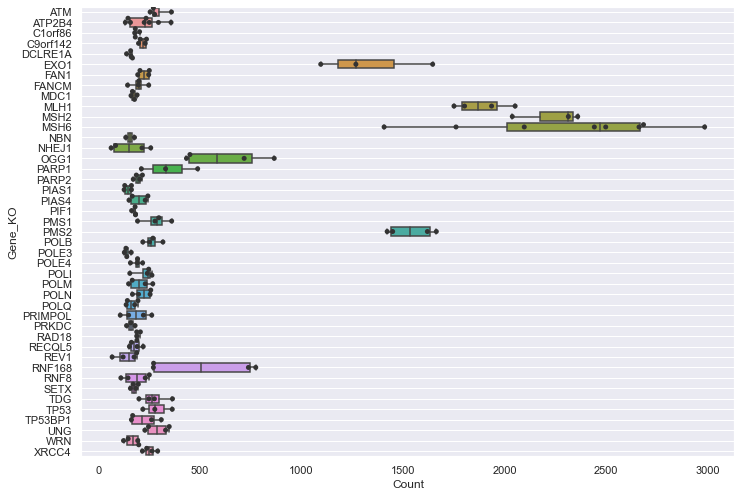

In [20]:
# sns.set_theme(style="whitegrid")
# sns.set(rc={'figure.figsize':(11.7,8.27)})

# ax = sns.swarmplot(x = "Count", y = "Gene_KO", data = zou, color=".2")
# ax = sns.boxplot(x = "Count", y = "Gene_KO", data = zou, whis = np.inf)
# plt.grid()
# plt.show()

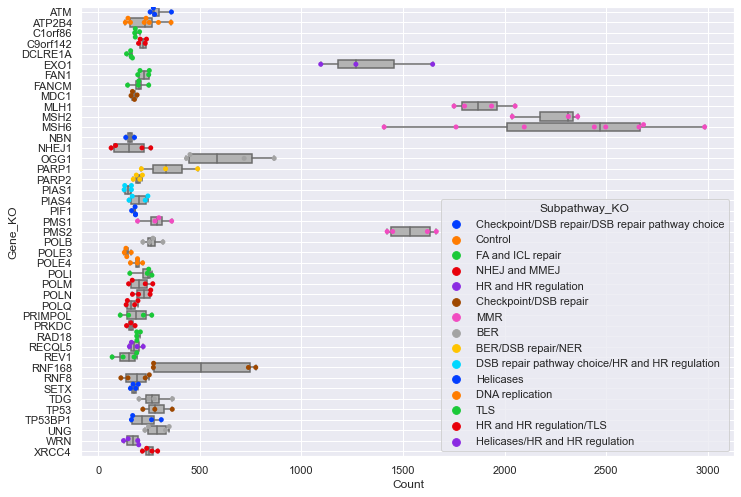

In [14]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

num_labels = len(set(zou.loc[:, ['Subpathway_KO']].values.flatten()))
ax = sns.swarmplot(x = "Count", y = "Gene_KO", data = zou, hue = 'Subpathway_KO',palette=sns.color_palette("bright", num_labels),)
ax = sns.boxplot(x = "Count", y = "Gene_KO", data = zou, whis = np.inf, color=".7")
plt.gca().yaxis.grid(True)
plt.gca().xaxis.grid(True)

plt.show()

### PCA
of all data and subsets of data

In [15]:
def screeplot(pca,title):
    var = pca.explained_variance_ratio_
    cumsum = np.cumsum(var)
    plt.plot(np.arange(pca.n_components)+1, var, 'ro-')
    plt.plot(np.arange(var.size) + 1, cumsum)
    plt.title('Scree Plot')
    plt.xlabel('PC')
    plt.ylabel('Proportion of Variance explained')
    plt.show()
#     plt.savefig('plots/multi/_{0}_screeplot_{}.png'.format(pca.n_components))



In [16]:
def EDA_PCA(zou, n_comp, title):
    
    features = zou.columns[0:96]
    x = zou.loc[:,features].values  # Separating out the target
    x = StandardScaler().fit_transform(x)
    
    pca = PCA(n_components=n_comp)
    pc = pca.fit_transform(x)
    principal_df = pd.DataFrame(data= pc, columns= np.arange(n_comp)+1)
    final_df = pd.concat([principal_df, zou[['Gene_KO','Subpathway_KO','Count']].reset_index(drop=True)], axis =1)

    plt.figure(figsize=(12,8))

    num_labels = len(set(zou.loc[:, ['Subpathway_KO']].values.flatten()))
    
    sns.scatterplot(
        x= 1 , y= 2,
        hue="Subpathway_KO",
        size = "Count",
        sizes=(50,500),
        palette=sns.color_palette("bright", num_labels),
        data=final_df,
        alpha=0.9,
        legend ='auto'
    )
    
    plt.title('PCA - {0} - {1} - {2}'.format(*title))
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    screeplot(pca, title)
    
#     print(final_df)

    
    
def EDA_UMAP(zou, n_comp, title, metric='euclidean', n_neighbors= 15):
    '''
    UMAP settings:
    n_neighbors : 15 (default)
        local (low value) vs global (high value) structure
    min_dist : 0.1 (default)
        minimum distance between points in low dim
    n_components : 2
        number of dimensions
    metric : 'cosine'
    '''
    features = zou.columns[0:96]
    x = zou.loc[:,features].values  # Separating out the target
    x = StandardScaler().fit_transform(x)

    reducer = umap.UMAP(random_state=42, n_components=n_comp, metric=metric, n_neighbors = n_neighbors)
    embedding = reducer.fit_transform(x)

    final_df = pd.DataFrame(data=embedding, columns=np.arange(n_comp) + 1)
    final_df = pd.concat([final_df, zou[['Gene_KO','Subpathway_KO','Count']].reset_index(drop=True)], axis =1)
    
    plt.figure(figsize=(12,8))
    
    num_labels = len(set(zou.loc[:, ['Subpathway_KO']].values.flatten()))
    
    sns.scatterplot(
        x= 1 , y= 2,
        hue="Subpathway_KO",
        size = "Count",
        sizes=(50,500),
        palette=sns.color_palette("bright", num_labels),
        data=final_df,
        alpha=0.9,
        legend ='auto'
    )
    
    plt.title('UMAP - {0} - {1} - {2}'.format(*title))
    plt.xlabel('axis 1')
    plt.ylabel('axis 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
#     print(final_df)


    


### ALL DATA

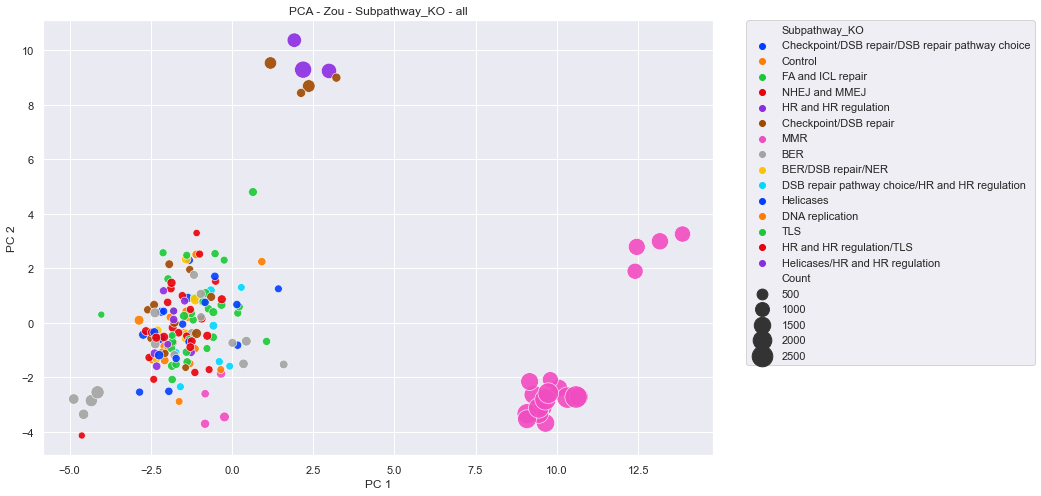

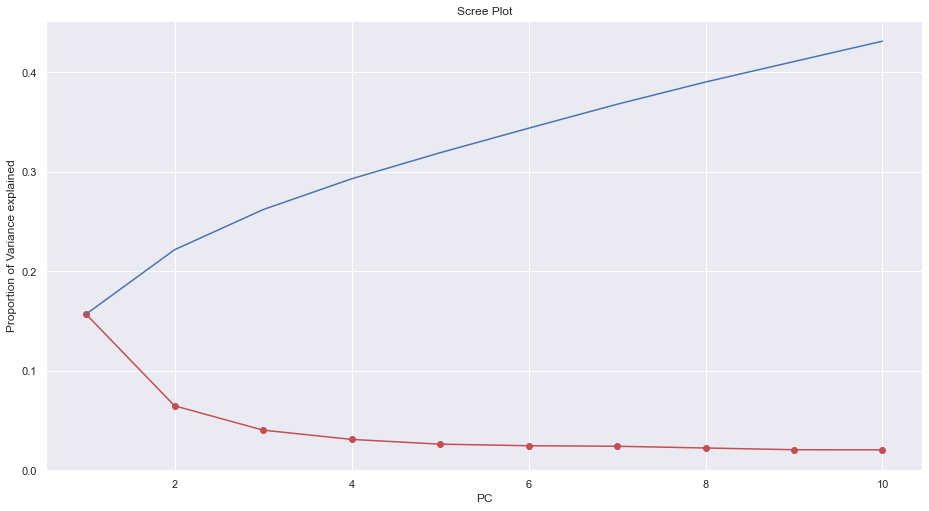

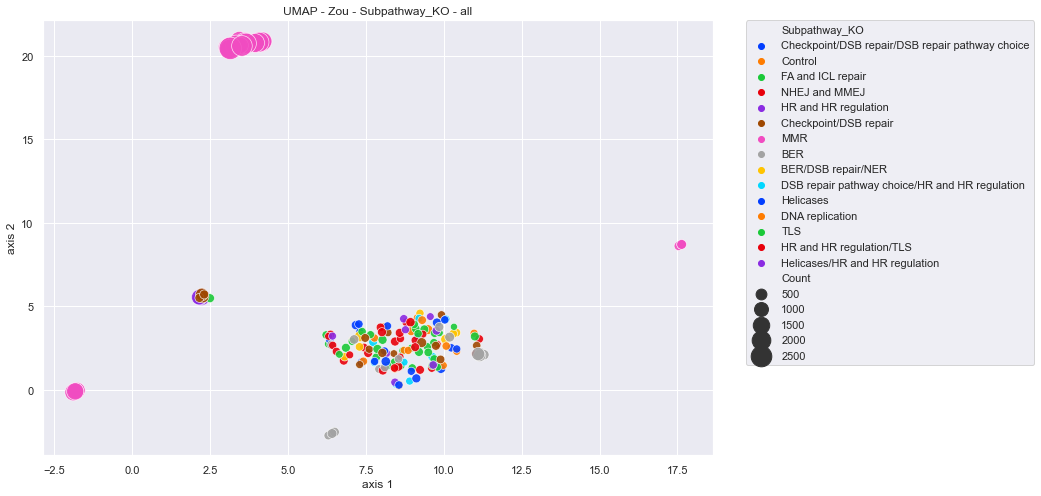

In [91]:

# [ DATASET ; LABELED ; FILTER ; COMPARE to ]
title = ['Zou', 'Subpathway_KO', 'all']


EDA_PCA(zou, 10, title)
EDA_UMAP(zou, 2, title, n_neighbors = 4)

In [18]:
def filter_in(zou, pw, gen):
    '''
    zou = all data
    pw = list of pathway labels to be KEPT
    gen = list of gene labels to be KEPT
    '''
    # PATHWAY
    pathway = set(zou.loc[:, ['Subpathway_KO']].values.flatten()) 
    pathway.difference_update(pw)   
    zou_path = zou[~zou['Subpathway_KO'].isin(pathway)]
    
    # GENES
    genes = set(zou.loc[:, ['Gene_KO']].values.flatten()) 
    genes.difference_update(gen)    
    zou_gene = zou[~zou['Gene_KO'].isin(genes)] 
    zou_filtered = pd.concat([zou_gene,zou_path]).drop_duplicates()
    return zou_filtered
    
def filter_out(zou, pw, gen):
    '''
    zou = all data
    pw = list of pathway labels to be REMOVED
    gen = list of gene labels to be REMOVED
    '''
    # PATHWAY
    pathway = set(zou.loc[:, ['Subpathway_KO']].values.flatten()) 
    pathway.intersection_update(pw)    
    zou = zou[~zou['Subpathway_KO'].isin(pathway)] 
    
    # GENES
    genes = set(zou.loc[:, ['Gene_KO']].values.flatten()) 
    genes.intersection_update(gen)    
    zou = zou[~zou['Gene_KO'].isin(genes)] 
    return zou

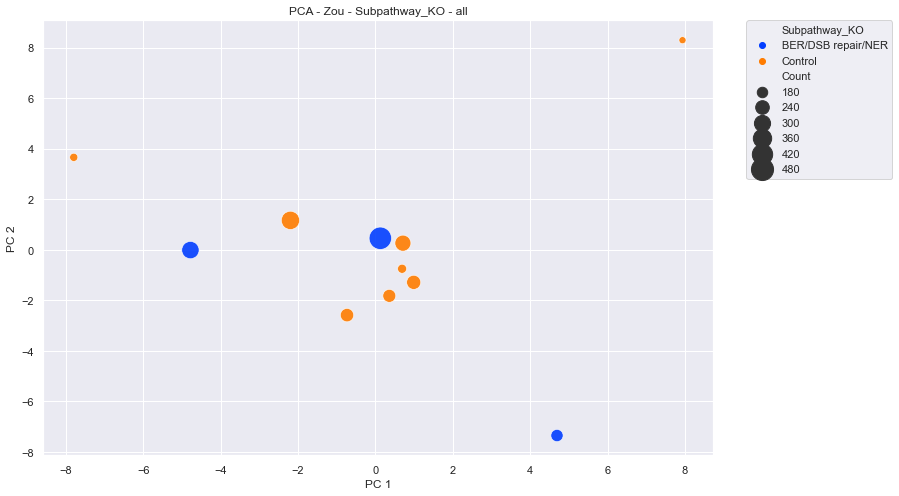

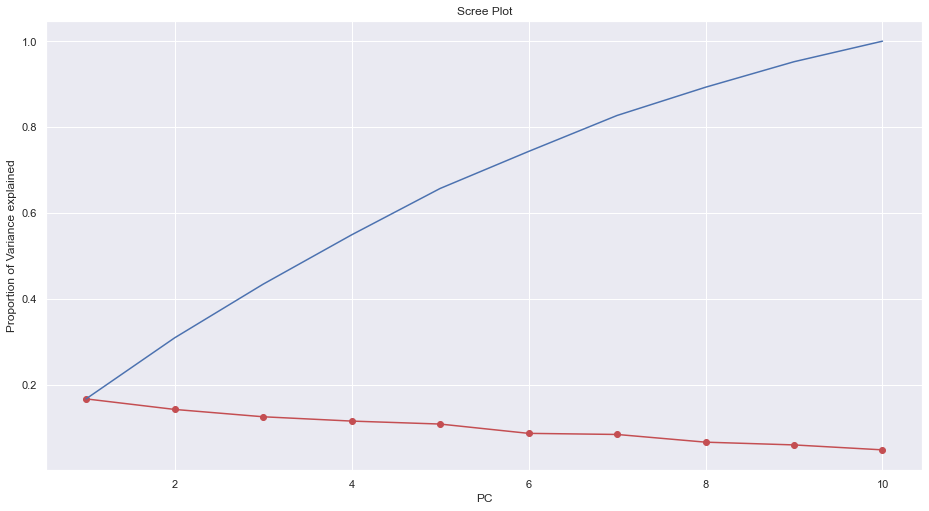

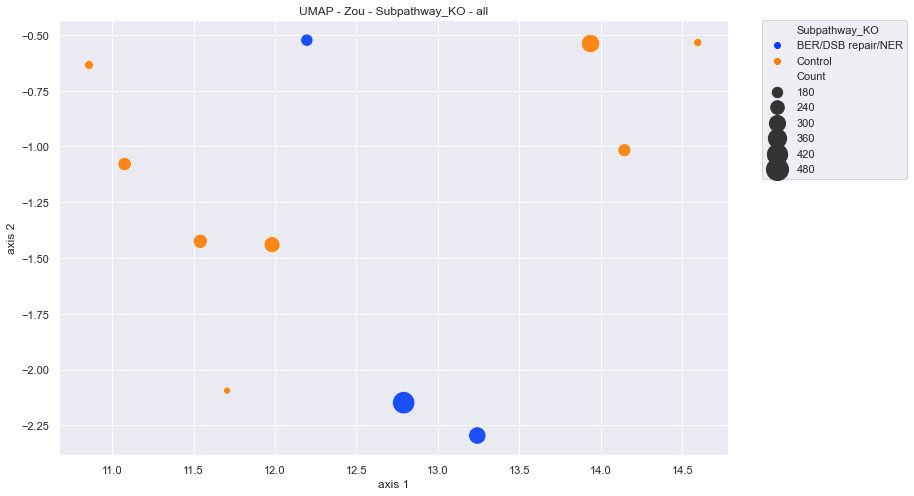

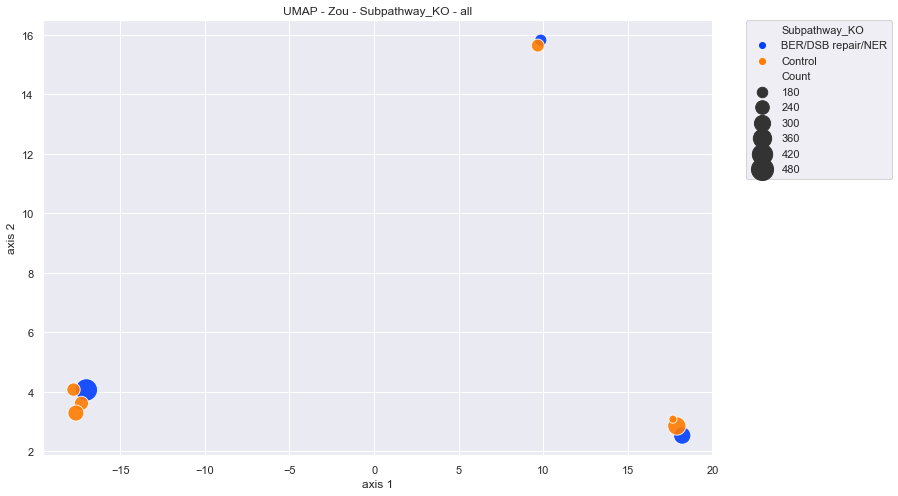

In [96]:
zou = load_zou()

# [ DATASET ; LABELED ; FILTER ; COMPARE to ]
title = ['Zou', 'Subpathway_KO', 'all']


# FILTER IN (which kept)
# pw = ['Control','MMR']
# gen = ['EXO1', 'RNF168','OGG1','UNG']
pw = ['Control']
gen = ['PARP1']
#ALL:
# gen = set(zou.loc[:, ['Gene_KO']].values.flatten())

zou_filtered_in = filter_in(zou, pw, gen)

EDA_PCA(zou_filtered_in, 10, title)
EDA_UMAP(zou_filtered_in, 2, title, n_neighbors = 2)
EDA_UMAP(zou_filtered_in, 2, title, metric='cosine', n_neighbors = 2)


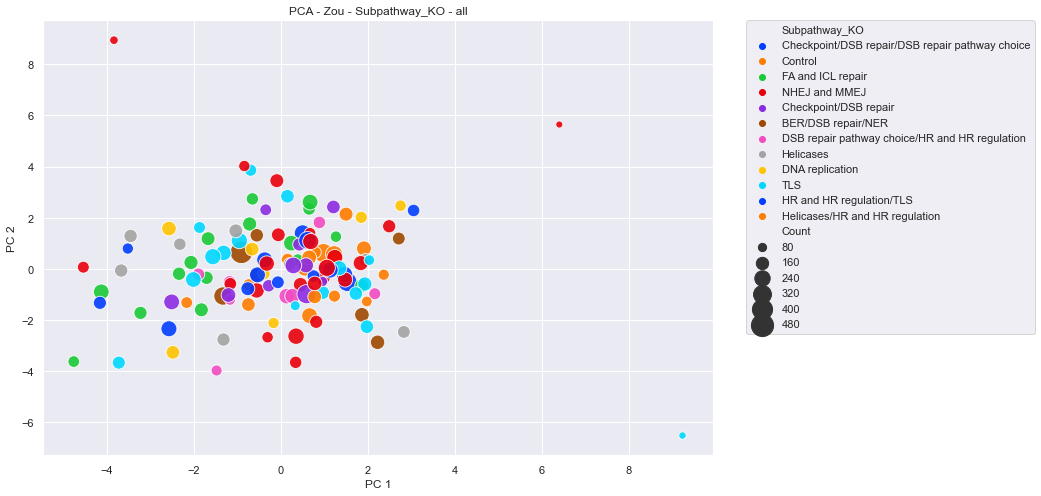

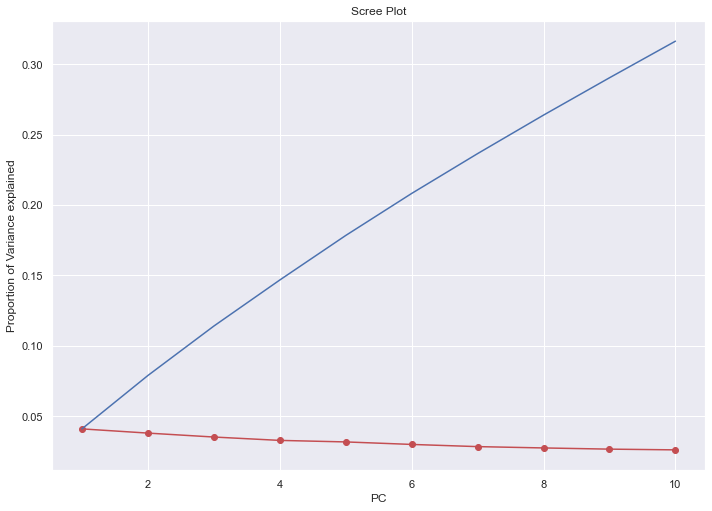

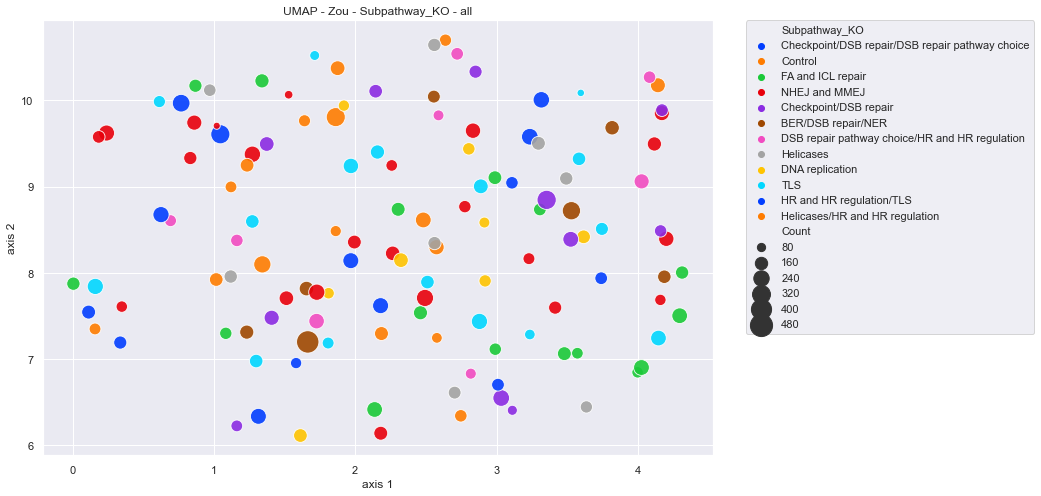

In [20]:
zou = load_zou()

# [ DATASET ; LABELED ; FILTER ; COMPARE to ]
title = ['Zou', 'Subpathway_KO', 'all']


# FILTER OUT (which removed)
pw = ['MMR', 'BER']
gen = ['EXO1', 'RNF168']
zou_filtered_out = filter_out(zou, pw, gen)

EDA_PCA(zou_filtered_out, 10, title)
EDA_UMAP(zou_filtered_out, 2, title, n_neighbors= 4)

### Similarity of Profiles

* Clustermap
* Self similiarity
* Similarity to Cosmic signatures

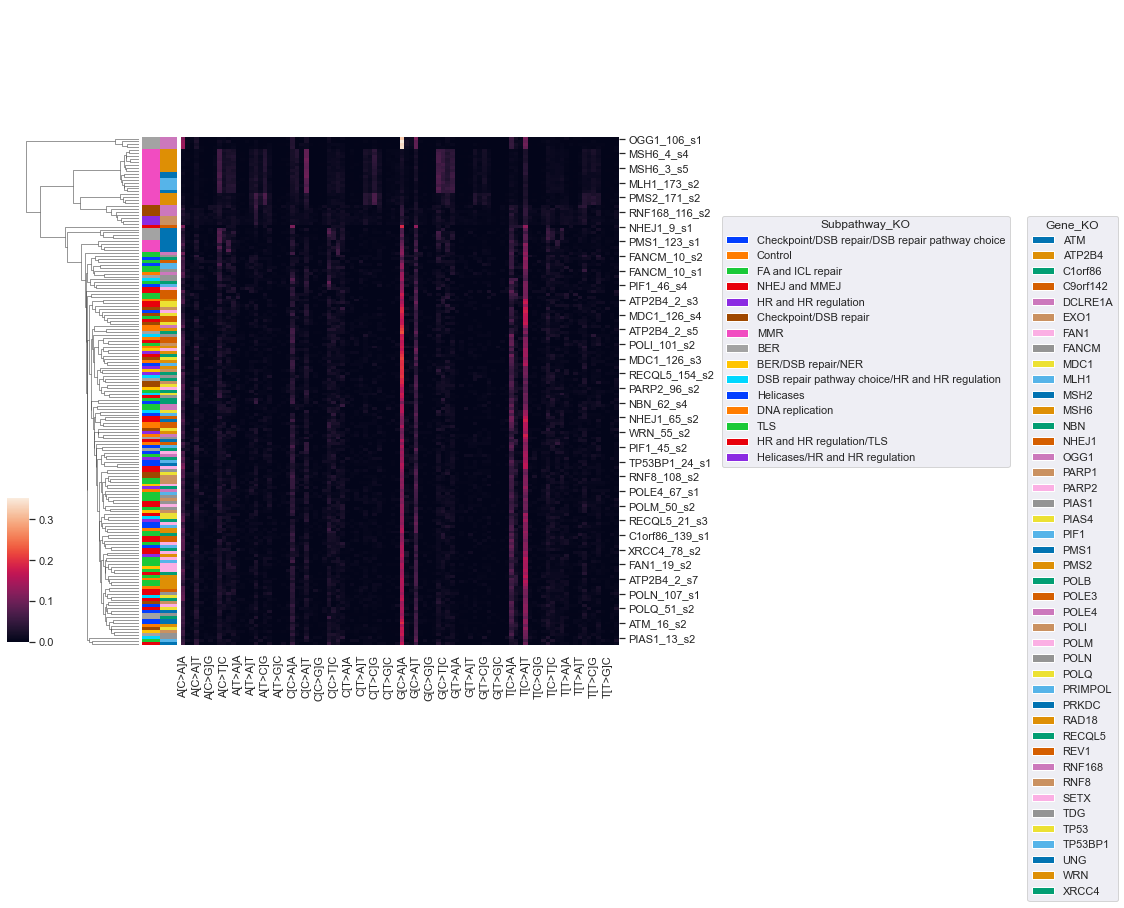

In [21]:
# CLUSTERMAP
zou = load_zou()

# FILTER IN (which kept)
pw = ['Control','BER']
# gen = []
gen = ['EXO1', 'RNF168']
#ALL:
# gen = set(zou.loc[:, ['Gene_KO']].values.flatten())

# zou_filtered_in = filter_in(zou, pw, gen)
zou_filtered_in = zou

features = zou_filtered_in.columns[0:96]

pathways = zou_filtered_in.pop("Subpathway_KO")
lut = dict(zip(pathways.unique(), sns.color_palette("bright", len(pathways.unique())) ))
color_path = pathways.map(lut)

gene = zou_filtered_in.pop("Gene_KO")
lut2 = dict(zip(gene.unique(), sns.color_palette("colorblind", len(gene.unique())) ))
color_gene = gene.map(lut2)


sns.clustermap(zou_filtered_in.loc[:,features],
               row_cluster= True,
               col_cluster = False,
               row_colors = [color_path, color_gene],
               cbar_pos = (0, 0.1, .03, .2)
              )

handles2 = [Patch(facecolor=lut2[name]) for name in lut2]
leg2 = plt.legend(handles2, lut2, title='Gene_KO',
           bbox_to_anchor=(1.55, 0.7), bbox_transform=plt.gcf().transFigure, loc='upper right')

handles = [Patch(facecolor=lut[name]) for name in lut]
leg1 = plt.legend(handles, lut, title='Subpathway_KO',
           bbox_to_anchor=(1.4, 0.7), bbox_transform=plt.gcf().transFigure, loc='upper right')


plt.gca().add_artist(leg2)

plt.show()

(46, 100)


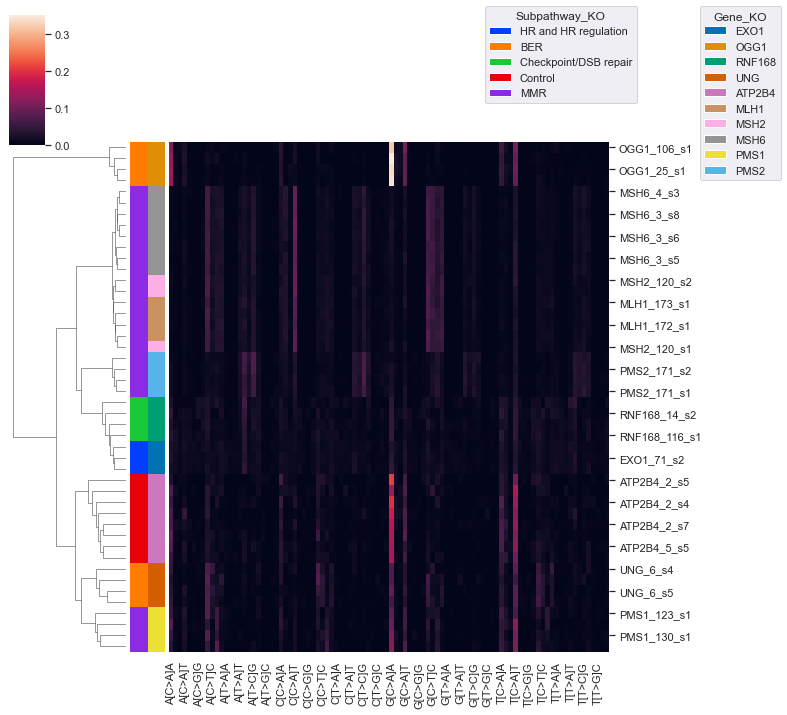

In [22]:
# CLUSTERMAP
zou = load_zou()

# FILTER IN (which kept)
pw = ['Control','MMR']
# gen = []
gen = ['EXO1', 'RNF168','OGG1','UNG']
#ALL:
# gen = set(zou.loc[:, ['Gene_KO']].values.flatten())

zou_filtered_in = filter_in(zou, pw, gen)
# zou_filtered_in = zou

print(zou_filtered_in.shape)

features = zou_filtered_in.columns[0:96]

pathways = zou_filtered_in.pop("Subpathway_KO")
lut = dict(zip(pathways.unique(), sns.color_palette("bright", len(pathways.unique())) ))
color_path = pathways.map(lut)

gene = zou_filtered_in.pop("Gene_KO")
lut2 = dict(zip(gene.unique(), sns.color_palette("colorblind", len(gene.unique())) ))
color_gene = gene.map(lut2)


sns.clustermap(zou_filtered_in.loc[:,features],
               row_cluster= True,
               col_cluster = False,
               row_colors = [color_path, color_gene],
              )

handles = [Patch(facecolor=lut[name]) for name in lut]
leg1 = plt.legend(handles, lut, title='Subpathway_KO',
           bbox_to_anchor=(0.9, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

handles2 = [Patch(facecolor=lut2[name]) for name in lut2]
leg2 = plt.legend(handles2, lut2, title='Gene_KO',
           bbox_to_anchor=(1.1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')
plt.gca().add_artist(leg1)

plt.show()

## Mutational Profiles

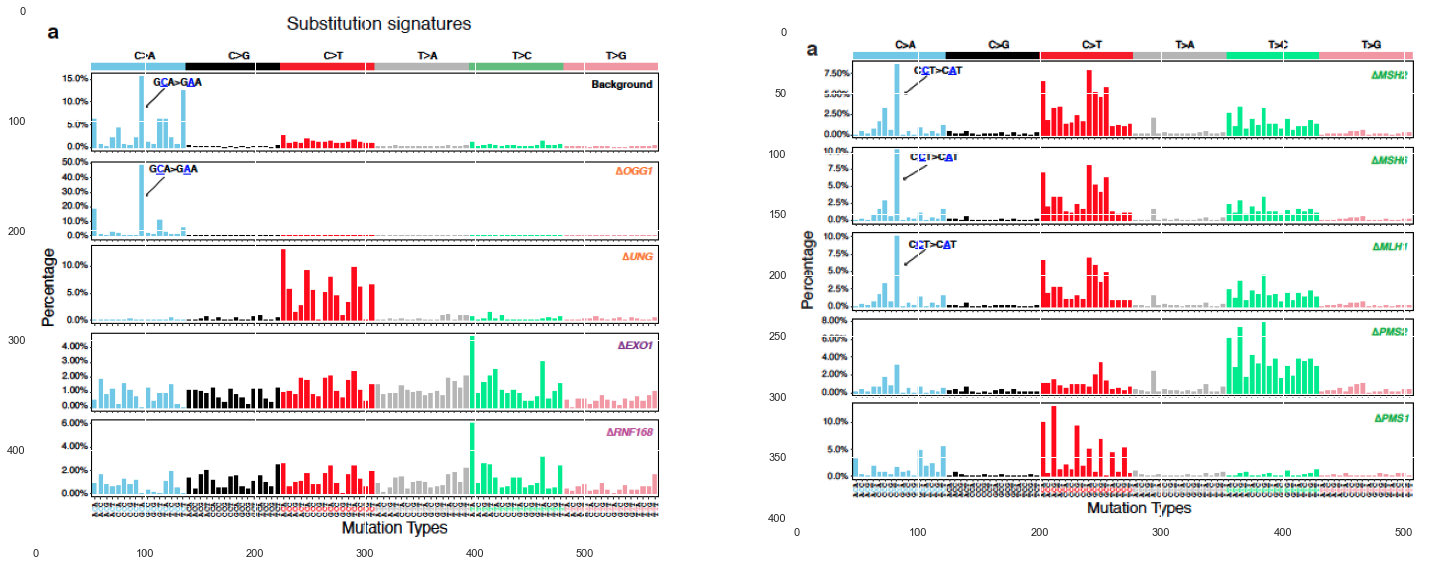

In [24]:
rcParams['figure.figsize'] = 25 ,25
# read images
img_A = mpimg.imread("C:/Users/sande/PycharmProjects/MEP_data/figures/Zou_profiles_1.png")
img_B = mpimg.imread("C:/Users/sande/PycharmProjects/MEP_data/figures/Zou_profiles_MMR.png")

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A);
ax[1].imshow(img_B);

### Similarity

In [25]:
def cossim(A, B):
    '''return cosine similarity between 2 vectors'''
    return np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B))

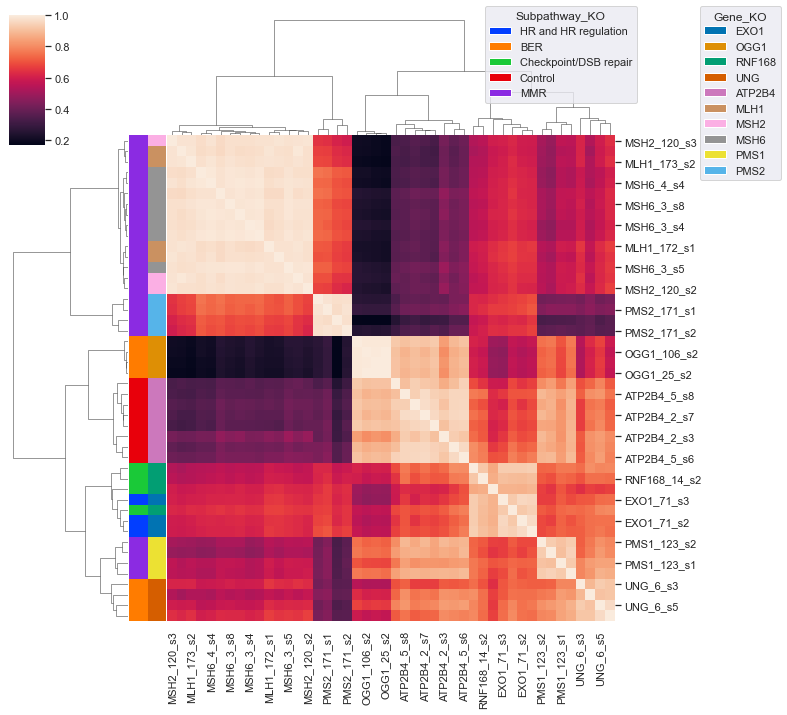

In [87]:
zou = load_zou()

# FILTER IN (which kept)
pw = ['Control','MMR']
# gen = []
gen = ['EXO1', 'RNF168','OGG1','UNG']
#ALL:
# gen = set(zou.loc[:, ['Gene_KO']].values.flatten())

zou_filtered_in = filter_in(zou, pw, gen)
# zou_filtered_in = zou

n_samp, n_feat = zou_filtered_in.shape

features = zou.columns[0:96]
data = zou_filtered_in.loc[:,features].values

similarity = np.zeros((n_samp, n_samp))
for i in range(n_samp):
    for j in range(i+1):
        similarity[i,j] = cossim(data[i,:], data[j,:])
        similarity[j, i] = similarity[i,j]
            
genes = zou_filtered_in.index.values
# ax = sns.heatmap(similarity, annot=False, xticklabels = genes, yticklabels= genes)
# plt.show()

sims = pd.DataFrame(data=similarity, index = genes, columns= genes)

pathways = zou_filtered_in.pop("Subpathway_KO")
lut = dict(zip(pathways.unique(), sns.color_palette("bright", len(pathways.unique())) ))
color_path = pathways.map(lut)

gene = zou_filtered_in.pop("Gene_KO")
lut2 = dict(zip(gene.unique(), sns.color_palette("colorblind", len(gene.unique())) ))
color_gene = gene.map(lut2)

sns.clustermap(sims,
               row_colors = [color_path, color_gene]
              )


handles = [Patch(facecolor=lut[name]) for name in lut]
leg1 = plt.legend(handles, lut, title='Subpathway_KO',
           bbox_to_anchor=(0.9, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

handles2 = [Patch(facecolor=lut2[name]) for name in lut2]
leg2 = plt.legend(handles2, lut2, title='Gene_KO',
           bbox_to_anchor=(1.1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')
plt.gca().add_artist(leg1)




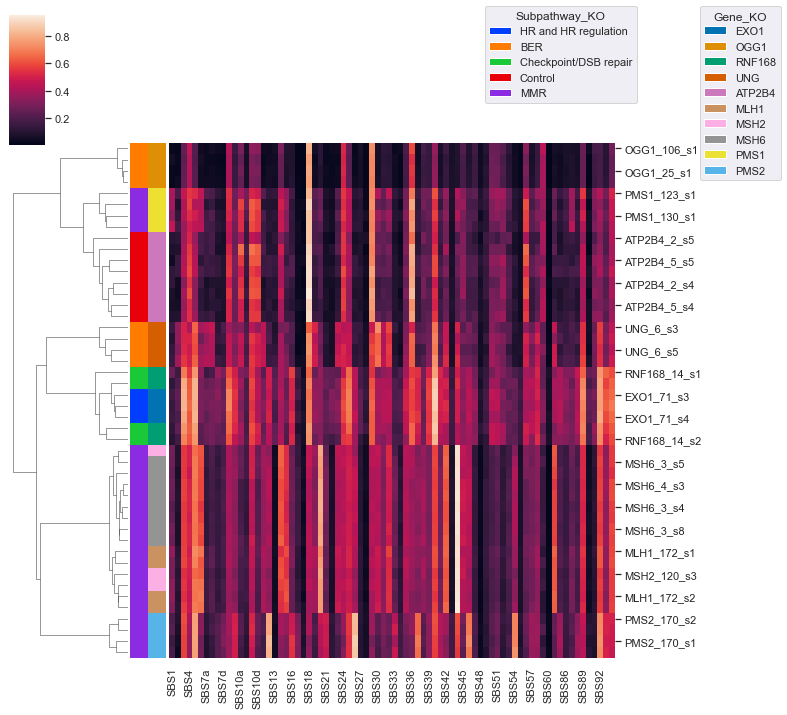

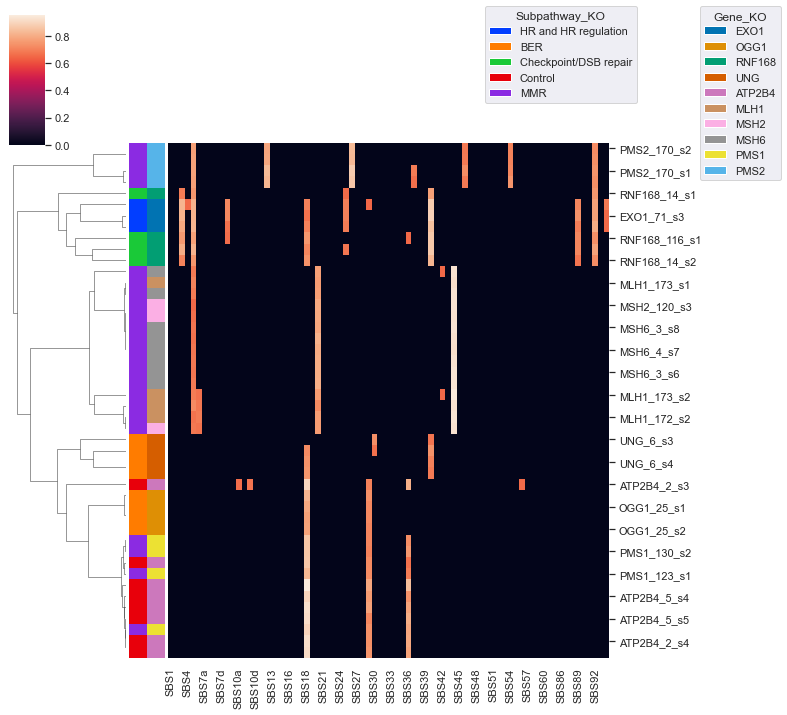

'\n\n'

In [80]:
zou = load_zou()
cosmic_temp = pd.read_csv('C:/Users/sande/PycharmProjects/MEP_data/data/COSMIC_v3.2_SBS_GRCh37.txt', delimiter='\t', index_col= 'Type')
cosmic = cosmic_temp.values

# FILTER IN (which kept)
pw = ['Control','MMR']
# gen = []
gen = ['EXO1', 'RNF168','OGG1','UNG']
#ALL:
# gen = set(zou.loc[:, ['Gene_KO']].values.flatten())

zou_filtered_in = filter_in(zou, pw, gen)
# zou_filtered_in = zou

n_samp, n_feat = zou_filtered_in.shape

features = zou.columns[0:96]
data = zou_filtered_in.loc[:,features].values
     
genes = zou_filtered_in.index.values
SBS = cosmic_temp.columns.values

similarity = np.zeros((n_samp, 78))
similarity_2 = np.zeros((n_samp, 78))

for i in range(n_samp):
    for j in range(78):
#         similarity[i,j] = cossim(data[i,:], data[j,:])
        similarity[i,j] = cossim(data[i,:], cosmic[:,j])
        if similarity[i,j] > 0.65:
            similarity_2[i,j] = similarity[i,j]
        
    
# sns.clustermap(zou_filtered_in.loc[:,features],
#                row_cluster= True,
#                col_cluster = False,
#                row_colors = [color_path, color_gene],
#                cbar_pos = (0, 0.1, .03, .2)
#               )
    
pathways = zou_filtered_in.pop("Subpathway_KO")
lut = dict(zip(pathways.unique(), sns.color_palette("bright", len(pathways.unique())) ))
color_path = pathways.map(lut)

gene = zou_filtered_in.pop("Gene_KO")
lut2 = dict(zip(gene.unique(), sns.color_palette("colorblind", len(gene.unique())) ))
color_gene = gene.map(lut2)
    
# Similarity to COSMIC    
sims = pd.DataFrame(data=similarity, index = genes, columns= SBS)
sns.clustermap(sims,
               row_cluster= True,
               col_cluster = False,
              row_colors = [color_path, color_gene])

handles = [Patch(facecolor=lut[name]) for name in lut]
leg1 = plt.legend(handles, lut, title='Subpathway_KO',
           bbox_to_anchor=(0.9, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

handles2 = [Patch(facecolor=lut2[name]) for name in lut2]
leg2 = plt.legend(handles2, lut2, title='Gene_KO',
           bbox_to_anchor=(1.1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')
plt.gca().add_artist(leg1)
plt.show()



# FILTERED (Treshold)
sims_2 = pd.DataFrame(data=similarity_2, index = genes, columns= SBS)
sns.clustermap(sims_2,
               row_cluster= True,
               col_cluster = False,
              row_colors = [color_path, color_gene]
              )
handles = [Patch(facecolor=lut[name]) for name in lut]
leg1 = plt.legend(handles, lut, title='Subpathway_KO',
           bbox_to_anchor=(0.9, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

handles2 = [Patch(facecolor=lut2[name]) for name in lut2]
leg2 = plt.legend(handles2, lut2, title='Gene_KO',
           bbox_to_anchor=(1.1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')
plt.gca().add_artist(leg1)
plt.show()
# print(sims_2)

'''

'''
# sns.heatmap(similarity, xticklabels = SBS, yticklabels= genes)        
        

In [86]:
# EXO/RNF
print(sims_2.loc['EXO1_71_s4','SBS3']) 
print(sims_2.loc['EXO1_71_s4','SBS5'])
print(sims_2.loc['EXO1_71_s4','SBS40']) #and PMS1?


# MMR 2
print(sims_2.loc['PMS2_171_s1','SBS26'])

# MMR
print(sims_2.loc['MLH1_173_s2','SBS44'])
print(sims_2.loc['MLH1_173_s2','SBS20'])

# Background ; PMS1 ; OGG1 ; UNG
print(sims_2.loc['PMS1_130_s1','SBS18'])
# print(sims_2.loc['PMS1_130_s1','SBS29'])
# print(sims_2.loc['PMS1_130_s1','SBS36'])

# BER
print(sims_2.loc['UNG_6_s3','SBS40'])
print(sims_2.loc['UNG_6_s3','SBS30'])
print(sims_2.loc['UNG_6_s3','SBS40'])



0.7866922489783978
0.8177570806726918
0.8447986809358313
0.8284421302766838
0.9496651376755707
0.7580650261334365
0.8558238707905768
0.675838173165699
0.7302747083383038


### EXO/RNF   (HR and Checkpoint/DSB repair)
LITERATURE : ?  
DATA       : 3 (HR deficiency) ; 5 ; 40? (unknown etiology)


### MMR
LITERATURE : 6 ; 14 ; 15; 20 ; 21 ; 26 ; 44  
DATA       : 20 ; 26 (PMS2) ; 44 

### BER
LITERATURE : 30 (NTHL1) ; 36 (MUTYH) ; 18 (MUTYH)  
DATA       : 30 (UNG) ; 18 (OGG1/background)
* All DNA glycossylases
* OGG1 and MUTYH result in same substrate (8-oxoG)


